#### Analysis of multiple stocks - for simulation over the course of n years at variable buy in frequency

Goal: This script simulates any number (typically 2) years of n-weekly prediction/closing_cost determinations and simulates for a series of chosen stocks if it is better to invest a consistent price or buy in higher/lower depending on the current performance of the stock.

Take any number of stocks and run a trendline through a series of overlapping cycles of variable length, creating a linear prediction to be applied. Assess the theoretical performance of adjusting contributions as compared to contributing a consistent amount over time.


In [356]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
from datetime import date
import math
from sys import exit

import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS

ymd = str(date.today().year) + str(date.today().month).zfill(2) + str(date.today().day).zfill(2)
ymd


'20220124'

In [357]:
### doing
# enumerate
# Add functions
    # Define a function for each strategy. Opt1, opt2 etc. Should be able to get them down to a few variables
# Add comprehensions
# create a strategy to find the ideal stocks to put bigger baseline investments into


### To do
# fix the copy errors - do it right


### bigger changes that might warrant a new doc entirely
# be able to do any unit of time, not just days - make it 'units' of time
    # so I can check on hypothetical minute to minute trading
# Start testing buy/sell every period based on a set budget
    # will likely be a big job. maybe a lot of changes needed
    # will possibly need to make it it's own script
    # I do still want to compare to a standard buy and hold consistently approach as the baseline


### Fixed/Done
# are all ranges 1-260 or are some 0-259? - one of them was corrected, the one that sets the pred independent variable (aka index)
# test the dynamic roll_days - is it implemented everywhere it should be and everything works as expected? - seems good now
# Fix the graphs to be dynamic for dates - esp the 3 graphs stuck together - can I make the number of stuck visuals dynamic? - dropped for now
# Fix the final statement to say profit/loss or above/below dynamically
    # seems to have an issue with the reversal of percents when the total profits are negative
    # need to test with net loss stocks
# Test for different 3 year periods of time
# Fact check the dynamic dates - is everything really working?
# I really need to fix the invest days to be always on Monday or something instead of every 10 trading days
    # I can't actually trust this method until I do this
    # probably means actually using time series instead of the index replacement -- nope
# be able to run on SP500
    # SP500 core profit is unbeleiveable - any error in the code? -- a few 'weeks' variables were kept stagnant as 49
# error checking on too much history run
    # have a whole section dedicated to it and say which stock and by how much it misses
# Make a path to DL data and call to it again w/o issues
    # For flights w/o internet
# be able to do one stock at a time -- OR be able to bypass
# 3 options: every week, 2 weeks, 4 weeks, is ok if I can't do fully dynamic
# test nth week variable for odd n's that create non-integers, like investing on 3rd weeks
    # invest_weeks must be an integer
    # re-check all new facets of weeks and invest_weeks
# convert 'y' years of data to be 'w?' weeks.
    # calculate exactly how much data are needed based on weeks to look back + length of the regression. with a week or two buffer
# make the invest period dynamic
# make some logic to warn when I'm asking for too much data and one of the stocks hasn't been around long enough
# Fact check by trying different stocks entirely - do a series of poorly performing stocks, high performing stocks, and a mix
# swap to open instead of open, it's more true to my practice
# I'm picking heavy hitter stocks and then pretending I've been investing for 2 years
    # I need to pick a series of random stocks and see if I still beat baseline
# Add individual buy in prices. 
    # Do a 2 variable loop along with my j stock variable? Do a pre logic to pick custom buy ins or make all the same if only one chosen
# get opt5 ready or some other method
# something wrong with the last table output - opt 5, when pred/open2 > 1.2
    # the df data are ok, but this needs to be fixed ASAP
# add in flight 1 and flight 2 of biweekly options
# find BTC data - must do
    # either through another package or manual DL and upload
    # does the fact that BTC is daily mess up the code?
# optimize the code that creates the pred calculation. Only the last row in each dictionary entry is used



In [358]:
##### User choices go here #####


# choose stocks of interest
# stocks chosen must all have data for full range of dates
# stock_list = ['AAPL', 'AMD', 'AMZN', 'CRM', 'GOOG', 'INTC', 'MSFT', 'NVDA', 'QQQ', 'SBUX', 'SQ', 'TSLA', 'TSM'] # core list
stock_list = ['AAPL', 'AMZN', 'GOOG', 'INTC', 'MSFT', 'SBUX', 'SQ'] # flight 1
# stock_list = ['AMD', 'CRM', 'NVDA', 'QQQ', 'TSLA', 'TSM'] # flight 2

# stock_list = ['^GSPC'] # AKA S&P 500
# stock_list = ['VFIAX', 'VTIAX', 'VTSAX']
# stock_list = ['BTC-USD']
# stock_list = ['AAPL', 'SQ', 'TSLA'] # quicker for test runs
# stock_list = ['TDOC', 'PINS'] # for net loss test runs
# stock_list = ['OSBC', 'MZZ', 'AEPPL', 'LDOS', 'AXU', 'ACM', 'MIND', 'PESI', 'JBT', 'FMN', ] # randomly pulled stocks


# choose how much to contribute each weekly period
# may choose a single value for all stocks or a set of tailored values per stock
# contrib_amt = [10, 8, 5, 3, 5, 8, 5, 8, 5, 5, 5, 10, 8] # for core list
contrib_amt = [10, 5, 5, 8, 5, 5, 5] # flight 1
# contrib_amt = [8, 3, 8, 5, 10, 8] # flight 2


# contrib_amt = [10]
# contrib_amt = [25]
# contrib_amt = [350, 50, 100] # for 3 index list


# weeks to cover (not necessarily the number of weeks where investing occurs)
# 52 = 1 year, 104 = 2 years, etc
total_weeks = 104

# invest every nth week
# 1 = every week, 2 = every 2 weeks, etc
nth_week = 2

# number of days to roll into each linear regression.
# 260 will be about 1 year
# 65 will be about 1 quarter
# 21 will be about 1 month
# remember, a trading week is a bit less than 5 days on average
roll_days = 65

# opt 5 + 6: threshold of consistent buying vs increased buying
buyvalue = 1.2

# opt 7: threshold of consistent buying vs increased buying
buyvalue2 = 1

# opt 5: if buyvalue hits, how much to multiply
# current strategy is (contrib_amt * pred/open2 * multiplier)
multiplier = 3

# opt 6: if buyvalue hits, how much to multiply
# current strategy is (contrib_amt * multiplier)
multiplier2 = 4

# opt 7: if buyvalue hits, how much to multiply
# current strategy is (contrib_amt * pred/open2 * multiplier)
multiplier3 = 1.5


##### choices on the fence, maybe they should be actively chosen #####

# max amount to contribute per stock over the course of 2 years
# should be at least 50 times the bi-weekly contrib
# unlimited max is another viable strategy
invest = float('inf')
# invest = contrib_amt*invest_weeks


##### 'choices' that should really be left alone #####

# number of years to visualize
if stock_list == ['BTC-USD']:
    day_hist = (total_weeks*7)+roll_days+1 # choose for crypto ~ trading every day
else:
    day_hist = (total_weeks*5)+roll_days+1 # choose for stocks ~ trading about 5 days per week

# weeks to actually invest on
invest_weeks = math.floor(total_weeks/nth_week)


print('Total invest amount over', total_weeks, 'weeks:', invest)
print('Number of invest weeks:', invest_weeks)
print('Days of data to pull:', day_hist)


Total invest amount over 104 weeks: inf
Number of invest weeks: 52
Days of data to pull: 586


In [359]:
# duplicate contrib_amt for all stocks if only 1 listed
if len(contrib_amt) == len(stock_list):
    pass
elif len(contrib_amt) == 1: 
    contrib_amt = [contrib_amt[0] for x in enumerate(stock_list)]
else:
    print('Incorrect length of contrib_amt. Make it match the length of the stock list or be 1 value')
    exit()

contrib_amt

[10, 5, 5, 8, 5, 5, 5]

In [360]:
# Pull the data
df = yf.download(
        tickers = stock_list
        ,period = str(day_hist) + 'd'
        #,start = '2017-02-14' # to choose custom date ranges
        #,end = '2020-02-14' # to choose custom date ranges
    )

# allows a single stock to pass through, not just 2+ stocks. and passes through just closing
if len(stock_list) == 1:
    df[stock_list[0]] = df['Open']
    df = df[[stock_list[0]]]
else:
    df = df['Open']

# add an index and useable date
df['Index'] = np.arange(1,len(df)+1)
df['date'] = df.index

# error checking, if a stock doesn't have enough history based on the current needs
nlist = []
for i in stock_list:
    if pd.isna(df[i].iloc[0]) == True:
        nlist.append(i)
    else:
        pass

if len(nlist) >0:
    print('Stocks with not enough history', nlist)
    for j in nlist:
        print(j, 'missing days:', df['Index'].count()-df[j].count())
    exit() # Maybe not the best to add this. I still want to see the data
else:
    print('No stock history issues seen')

# in case the first row generates as nulls
# df = df.dropna() # not sure if necessary anymore

# establishing day of week, week number, trading day (each Monday)
df['dow'] = df['date'].dt.dayofweek
week_no_list = []
trade_day_list = []
week_no_var = 1
trade_day_var = 0

for i in range(len(df)):
    if i == 0:
        1
    elif df['dow'].iloc[i] > df['dow'].iloc[i-1]:
        week_no_var
        trade_day_var = 0
    else:
        week_no_var += 1
        trade_day_var = 1
    week_no_list.append(week_no_var)
    trade_day_list.append(trade_day_var)

df['week_no'] = week_no_list
df['trade_day'] = trade_day_list

# export data at current date/time
try:
    ymdt = ymd + '_' + datetime.datetime.now().strftime('%H%M%S')
    df.to_csv(f'C:/Users/james/OneDrive/Desktop/Projects/Stocks_1/stocks_raw_export_{ymdt}.csv', index = False)
except:
    print('Can\'t export data')

df

[*********************100%***********************]  7 of 7 completed
No stock history issues seen


,AAPL,AMZN,GOOG,INTC,MSFT,SBUX,SQ,Index,date,dow,week_no,trade_day
Date,,,,,,,,,,,,
2019-09-27,55.134998,1748.000000,1243.010010,50.630001,140.149994,90.300003,60.980000,1,2019-09-27,4,1,0
2019-09-30,55.224998,1726.989990,1220.969971,51.189999,138.050003,88.410004,60.959999,2,2019-09-30,0,2,1
2019-10-01,56.267502,1746.000000,1219.000000,51.970001,139.660004,88.629997,62.299999,3,2019-10-01,1,2,0
2019-10-02,55.764999,1727.739990,1196.979980,50.310001,136.250000,85.949997,61.230000,4,2019-10-02,2,2,0
2019-10-03,54.607498,1713.000000,1180.000000,49.500000,134.949997,84.300003,59.480000,5,2019-10-03,3,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-18,171.509995,3182.100098,2732.000000,55.310001,304.070007,99.169998,130.029999,582,2022-01-18,1,122,1
2022-01-19,170.000000,3175.239990,2738.770020,54.630001,306.290009,97.940002,129.005005,583,2022-01-19,2,122,0
2022-01-20,166.979996,3135.320068,2730.280029,53.860001,309.070007,97.489998,128.220001,584,2022-01-20,3,122,0


In [361]:
# make a list of indices that are the Mondays where the trade should take place
# always starting with the most recent Monday

df_trade_days = df['Index'][df['trade_day'] == 1]
df_trade_days = df_trade_days.tail(total_weeks)
df_trade_days = df_trade_days.tolist()

def reverse(rev):
    rev.reverse()
    return rev
df_trade_days = reverse(df_trade_days)

nth_wk = df_trade_days[::nth_week]

print(nth_wk)
print('Number of weeks picked:',len(nth_wk))


[586, 577, 567, 558, 548, 539, 529, 519, 509, 499, 490, 480, 470, 460, 450, 441, 431, 422, 412, 402, 392, 382, 373, 363, 353, 344, 334, 325, 316, 307, 297, 288, 278, 268, 258, 248, 239, 229, 219, 209, 199, 190, 180, 170, 161, 151, 141, 132, 122, 112, 102, 93]
Number of weeks picked: 52


In [362]:
# create 1 dataframe per invest week in a dictionary, each the length of the chosen invest period
# 0 is the most recent

dataframes = {}

for j in stock_list:
    for i in range(invest_weeks):
        x = nth_wk[i]-roll_days # roll_days sets how many rows in each df
        y = nth_wk[i]

        dataframes['data' + str(i)] = df.iloc[x:y]

print(dataframes['data0'])
print(dataframes['data' + str(invest_weeks-1)])

                  AAPL         AMZN         GOOG       INTC        MSFT  \
Date                                                                      
2021-10-21  148.809998  3414.250000  2843.840088  54.930000  307.170013   
2021-10-22  149.690002  3421.000000  2807.020020  50.389999  310.399994   
2021-10-25  148.679993  3335.000000  2776.209961  49.830002  309.359985   
2021-10-26  149.330002  3349.510010  2812.120117  49.400002  311.000000   
2021-10-27  149.360001  3388.000000  2798.050049  48.520000  316.000000   
...                ...          ...          ...        ...         ...   
2022-01-18  171.509995  3182.100098  2732.000000  55.310001  304.070007   
2022-01-19  170.000000  3175.239990  2738.770020  54.630001  306.290009   
2022-01-20  166.979996  3135.320068  2730.280029  53.860001  309.070007   
2022-01-21  164.419998  2999.000000  2660.239990  52.080002  302.690002   
2022-01-24  160.020004  2780.000000  2520.550049  51.480000  292.200012   

                  SBUX  

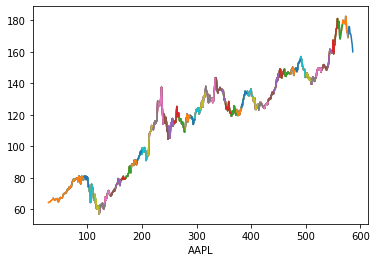

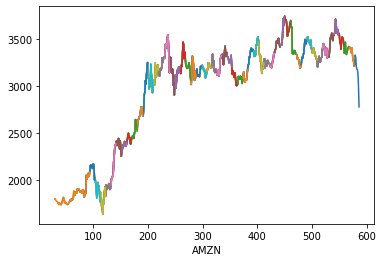

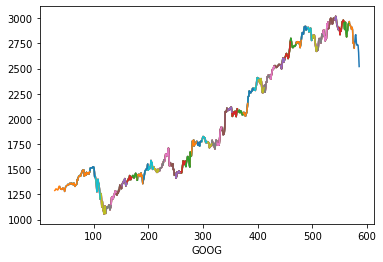

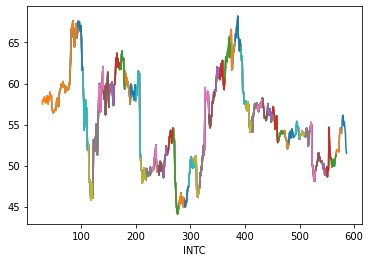

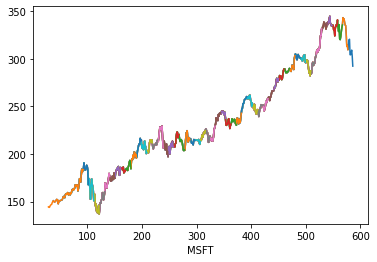

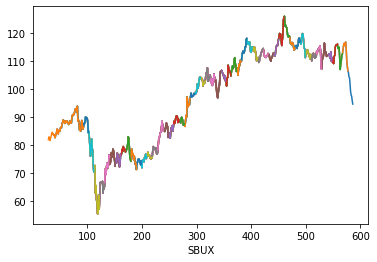

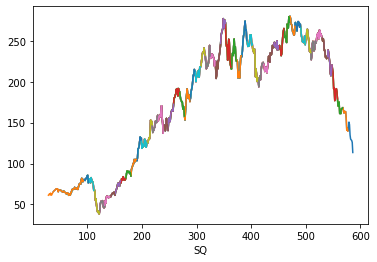

In [363]:
# shows each investing period, overlapping
### meh, less useful if I can't account for the dynamic investing periods

for i in stock_list:
    for j in range(len(dataframes)):
        x = dataframes['data' + str(j)]['Index']
        y = dataframes['data' + str(j)][str(i)]
        plt.plot(x, y)
        # m, b = np.polyfit(x, y, 1)
        # plt.plot(x, m*x + b)

    plt.xlabel(i)
    plt.show()

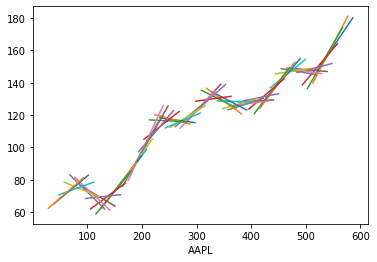

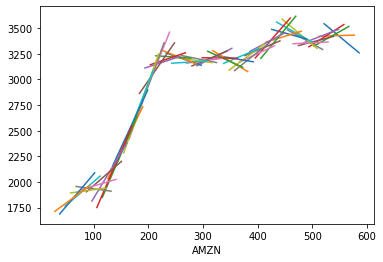

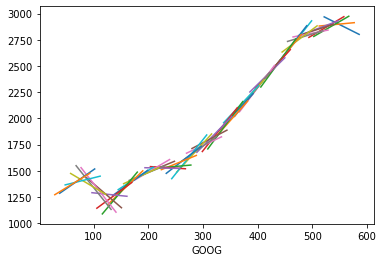

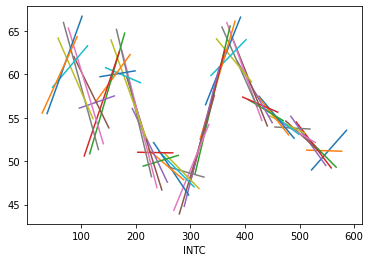

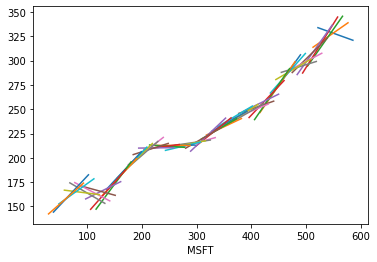

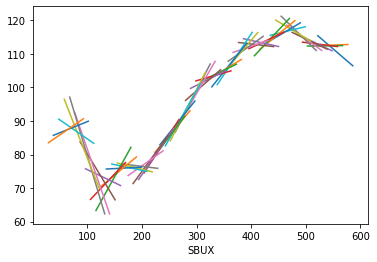

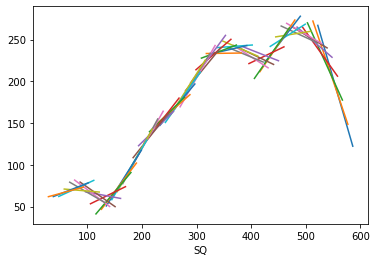

In [364]:
# plot only trendlines, every n weeks, each line representing the chosen length of data
# if the movement is too stable, these graphs won't be useable

for j in stock_list:
    for i in range(len(dataframes)):
        x = dataframes['data' + str(i)]['Index']
        y = dataframes['data' + str(i)][str(j)]

        m, b = np.polyfit(x, y, 1)
        plt.plot(x, m*x + b)

    plt.xlabel(j)
    plt.show()

In [365]:
# create pred and pred/open list for each of the n dataframes

for j in stock_list:
    for e in range(len(dataframes)):
        nlist = []
        ylist = []
        y = dataframes['data' + str(e)][str(j)]

        for i in range(1,len(dataframes['data0'])+1): # create pred
            if i == len(dataframes['data0']):
                x = range(1,roll_days+1) # range must be 1-roll_days, not the auto implied 0-(roll_days-1)
                m, b = np.polyfit(x, y, 1)
                d = m*i+b
                nlist.append(d)
            else:
                nlist.append(-1) # Skip calculating every row except the last one. Only the last is used

        dataframes['data' + str(e)][str(j) + ' pred'] = nlist

        for i in range(1,len(dataframes['data0'])+1): # create pred/open
            if i == len(dataframes['data0']):
                d = (dataframes['data' + str(e)][str(j) + ' pred'].iloc[i-1])/(dataframes['data' + str(e)][str(j)].iloc[i-1])
                ylist.append(d)
            else:
                ylist.append(-1) # Skip calculating every row except the last one. Only the last is used

        dataframes['data' + str(e)][str(j) + ' pred/open'] = ylist

dataframes['data0'] # just the most recent segment

C:\Users\james\AppData\Local\Temp/ipykernel_6020/270996094.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframes['data' + str(e)][str(j) + ' pred'] = nlist
C:\Users\james\AppData\Local\Temp/ipykernel_6020/270996094.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframes['data' + str(e)][str(j) + ' pred/open'] = ylist


,AAPL,AMZN,GOOG,INTC,MSFT,SBUX,SQ,Index,date,dow,...,GOOG pred,GOOG pred/open,INTC pred,INTC pred/open,MSFT pred,MSFT pred/open,SBUX pred,SBUX pred/open,SQ pred,SQ pred/open
Date,,,,,,,,,,,,,,,,,,,,,
2021-10-21,148.809998,3414.250000,2843.840088,54.930000,307.170013,113.930000,255.539993,522,2021-10-21,3,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
2021-10-22,149.690002,3421.000000,2807.020020,50.389999,310.399994,114.410004,259.880005,523,2021-10-22,4,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
2021-10-25,148.679993,3335.000000,2776.209961,49.830002,309.359985,114.739998,252.550003,524,2021-10-25,0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
2021-10-26,149.330002,3349.510010,2812.120117,49.400002,311.000000,114.919998,263.029999,525,2021-10-26,1,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
2021-10-27,149.360001,3388.000000,2798.050049,48.520000,316.000000,115.570000,261.920013,526,2021-10-27,2,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-18,171.509995,3182.100098,2732.000000,55.310001,304.070007,99.169998,130.029999,582,2022-01-18,1,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
2022-01-19,170.000000,3175.239990,2738.770020,54.630001,306.290009,97.940002,129.005005,583,2022-01-19,2,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
2022-01-20,166.979996,3135.320068,2730.280029,53.860001,309.070007,97.489998,128.220001,584,2022-01-20,3,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000


In [366]:
# pull the last 'open' and pred/open' from each dataframe in dataframes and make a new dataframe out of it
# each row is the last open price in a given period and the final pred/open derived from the linear trendline

df = pd.DataFrame()
add_index = np.arange(1,len(dataframes)+1)
df['Index'] = add_index

for j in stock_list:
    nlist = []
    ylist = []
    zlist = []

    for e in reversed(range(len(dataframes))):
        nlist.append(dataframes['data' + str(e)][str(j) + ' pred/open'].iloc[roll_days-1])
        ylist.append(dataframes['data' + str(e)][str(j)].iloc[roll_days-1])
        zlist.append(dataframes['data' + str(e)][str(j) + ' pred'].iloc[roll_days-1])

    df[str(j)] = pd.DataFrame(ylist)
    df[str(j) + ' pred'] = pd.DataFrame(zlist)
    df[str(j) + ' pred/open'] = pd.DataFrame(nlist)

df.tail(10)

,Index,AAPL,AAPL pred,AAPL pred/open,AMZN,AMZN pred,AMZN pred/open,GOOG,GOOG pred,GOOG pred/open,...,INTC pred/open,MSFT,MSFT pred,MSFT pred/open,SBUX,SBUX pred,SBUX pred/open,SQ,SQ pred,SQ pred/open
42,43,143.800003,154.291944,1.072962,3396.000000,3367.090096,0.991487,2780.003906,2930.884019,1.054273,...,0.997773,296.329987,307.386337,1.037311,111.349998,118.117301,1.060775,245.330002,268.414170,1.094094
43,44,141.759995,148.850195,1.050016,3279.389893,3302.320220,1.006992,2713.989990,2882.569562,1.062115,...,0.987016,287.399994,301.536184,1.049186,112.430000,113.854559,1.012671,235.610001,259.906700,1.103123
44,45,143.449997,144.995385,1.010773,3388.360107,3292.458208,0.971697,2824.270020,2834.844785,1.003744,...,0.991188,303.570007,299.154225,0.985454,111.440002,111.026111,0.996286,247.449997,246.728777,0.997085
45,46,148.990005,145.613497,0.977337,3361.800049,3364.967471,1.000942,2963.300049,2842.468483,0.959224,...,1.055782,331.359985,307.609509,0.928324,107.230003,111.066195,1.035775,255.119995,245.293323,0.961482
46,47,150.369995,146.899092,0.976918,3537.000000,3419.431913,0.966761,3000.000000,2897.434743,0.965812,...,1.011275,337.540009,323.269216,0.957721,112.120003,111.429035,0.993837,229.000000,240.010440,1.048081
47,48,159.369995,151.828084,0.952677,3547.639893,3488.270213,0.983265,2885.969971,2931.189213,1.015669,...,1.004372,334.940002,336.516251,1.004706,111.360001,110.949875,0.996317,220.460007,228.825861,1.037947
48,49,181.119995,164.095665,0.906005,3440.000000,3535.283570,1.027699,2968.879883,2970.603596,1.000581,...,0.968125,340.679993,344.869077,1.012296,116.160004,112.198393,0.965895,179.110001,206.218217,1.151350
49,50,177.089996,173.849566,0.981702,3420.739990,3516.234380,1.027916,2949.270020,2974.622901,1.008596,...,0.960347,335.459991,345.703314,1.030535,112.599998,112.476084,0.998900,168.149994,177.621993,1.056331
50,51,169.080002,181.035231,1.070708,3211.709961,3432.223246,1.068659,2701.979980,2913.205098,1.078174,...,0.947861,309.489990,338.969940,1.095253,106.620003,112.813329,1.058088,139.649994,148.600285,1.064091
51,52,160.020004,180.064629,1.125263,2780.000000,3259.287739,1.172406,2520.550049,2801.323341,1.111394,...,1.040535,292.200012,320.994350,1.098543,94.750000,106.469245,1.123686,113.500000,122.361461,1.078075


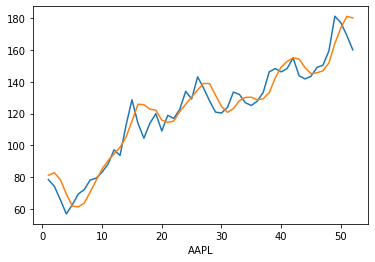

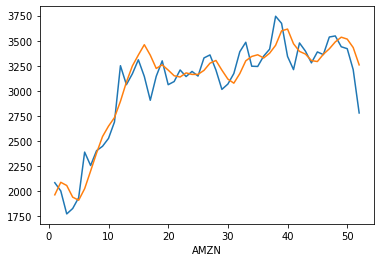

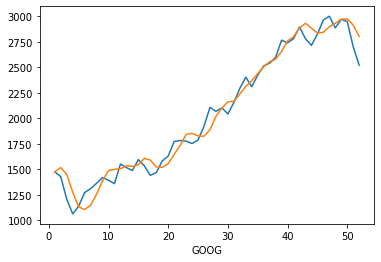

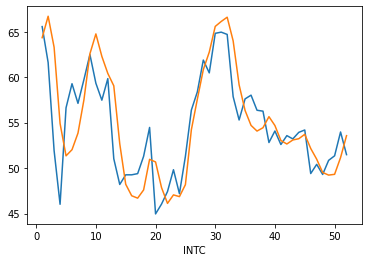

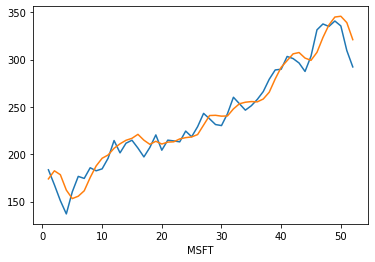

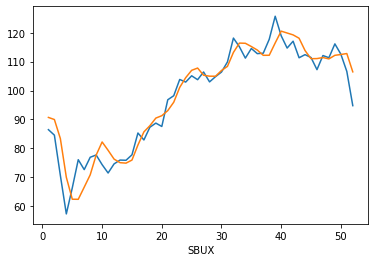

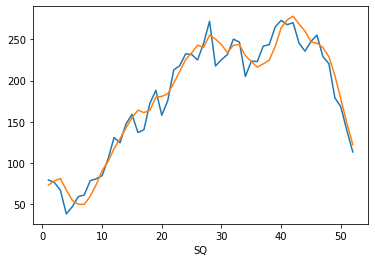

In [367]:
# plot for each stock the open price and the prediction price
# open (blue) below prediction (orange) = stock is underperforming

for i in stock_list:
    x = df['Index']
    y = df[str(i)]
    plt.plot(x, y)

    x = df['Index']
    y = df[str(i) + ' pred']
    plt.plot(x, y)

    plt.xlabel(i)
    plt.show()

#### At this point, the foundation is set and strategies can be created and tested.

In [368]:
# determine the weeks where pred/open is >1 and therefore they are better weeks to buy in
# steady stocks could be at about 50/50 but stocks exponentially rising could have open to 0 pred/open > 1

for j in stock_list:
    nlist = []
    for i in range(len(df)):
        if df[str(j) + ' pred/open'].iloc[i] >= 1:
            nlist.append(1)
        else:
            nlist.append(0)

    df[str(j) + ' >1'] = nlist

df.tail(10)

,Index,AAPL,AAPL pred,AAPL pred/open,AMZN,AMZN pred,AMZN pred/open,GOOG,GOOG pred,GOOG pred/open,...,SQ,SQ pred,SQ pred/open,AAPL >1,AMZN >1,GOOG >1,INTC >1,MSFT >1,SBUX >1,SQ >1
42,43,143.800003,154.291944,1.072962,3396.000000,3367.090096,0.991487,2780.003906,2930.884019,1.054273,...,245.330002,268.414170,1.094094,1,0,1,0,1,1,1
43,44,141.759995,148.850195,1.050016,3279.389893,3302.320220,1.006992,2713.989990,2882.569562,1.062115,...,235.610001,259.906700,1.103123,1,1,1,0,1,1,1
44,45,143.449997,144.995385,1.010773,3388.360107,3292.458208,0.971697,2824.270020,2834.844785,1.003744,...,247.449997,246.728777,0.997085,1,0,1,0,0,0,0
45,46,148.990005,145.613497,0.977337,3361.800049,3364.967471,1.000942,2963.300049,2842.468483,0.959224,...,255.119995,245.293323,0.961482,0,1,0,1,0,1,0
46,47,150.369995,146.899092,0.976918,3537.000000,3419.431913,0.966761,3000.000000,2897.434743,0.965812,...,229.000000,240.010440,1.048081,0,0,0,1,0,0,1
47,48,159.369995,151.828084,0.952677,3547.639893,3488.270213,0.983265,2885.969971,2931.189213,1.015669,...,220.460007,228.825861,1.037947,0,0,1,1,1,0,1
48,49,181.119995,164.095665,0.906005,3440.000000,3535.283570,1.027699,2968.879883,2970.603596,1.000581,...,179.110001,206.218217,1.151350,0,1,1,0,1,0,1
49,50,177.089996,173.849566,0.981702,3420.739990,3516.234380,1.027916,2949.270020,2974.622901,1.008596,...,168.149994,177.621993,1.056331,0,1,1,0,1,0,1
50,51,169.080002,181.035231,1.070708,3211.709961,3432.223246,1.068659,2701.979980,2913.205098,1.078174,...,139.649994,148.600285,1.064091,1,1,1,0,1,1,1
51,52,160.020004,180.064629,1.125263,2780.000000,3259.287739,1.172406,2520.550049,2801.323341,1.111394,...,113.500000,122.361461,1.078075,1,1,1,1,1,1,1


In [369]:
# square the pred/open number as a more extreme option for calculations

for j in stock_list:
    df[str(j) +' pred/open2'] = df[str(j) +' pred/open']**2 # make the value differences a little more pronounced

df.tail(10)

,Index,AAPL,AAPL pred,AAPL pred/open,AMZN,AMZN pred,AMZN pred/open,GOOG,GOOG pred,GOOG pred/open,...,MSFT >1,SBUX >1,SQ >1,AAPL pred/open2,AMZN pred/open2,GOOG pred/open2,INTC pred/open2,MSFT pred/open2,SBUX pred/open2,SQ pred/open2
42,43,143.800003,154.291944,1.072962,3396.000000,3367.090096,0.991487,2780.003906,2930.884019,1.054273,...,1,1,1,1.151248,0.983047,1.111492,0.995550,1.076014,1.125244,1.197042
43,44,141.759995,148.850195,1.050016,3279.389893,3302.320220,1.006992,2713.989990,2882.569562,1.062115,...,1,1,1,1.102533,1.014033,1.128088,0.974201,1.100792,1.025502,1.216879
44,45,143.449997,144.995385,1.010773,3388.360107,3292.458208,0.971697,2824.270020,2834.844785,1.003744,...,0,0,0,1.021662,0.944194,1.007503,0.982453,0.971119,0.992586,0.994179
45,46,148.990005,145.613497,0.977337,3361.800049,3364.967471,1.000942,2963.300049,2842.468483,0.959224,...,0,1,0,0.955188,1.001885,0.920111,1.114675,0.861786,1.072831,0.924448
46,47,150.369995,146.899092,0.976918,3537.000000,3419.431913,0.966761,3000.000000,2897.434743,0.965812,...,0,0,1,0.954368,0.934626,0.932792,1.022677,0.917230,0.987712,1.098473
47,48,159.369995,151.828084,0.952677,3547.639893,3488.270213,0.983265,2885.969971,2931.189213,1.015669,...,1,0,1,0.907593,0.966810,1.031583,1.008764,1.009434,0.992648,1.077335
48,49,181.119995,164.095665,0.906005,3440.000000,3535.283570,1.027699,2968.879883,2970.603596,1.000581,...,1,0,1,0.820845,1.056165,1.001162,0.937266,1.024744,0.932954,1.325606
49,50,177.089996,173.849566,0.981702,3420.739990,3516.234380,1.027916,2949.270020,2974.622901,1.008596,...,1,0,1,0.963738,1.056612,1.017267,0.922266,1.062003,0.997800,1.115834
50,51,169.080002,181.035231,1.070708,3211.709961,3432.223246,1.068659,2701.979980,2913.205098,1.078174,...,1,1,1,1.146415,1.142032,1.162460,0.898440,1.199580,1.119550,1.132289
51,52,160.020004,180.064629,1.125263,2780.000000,3259.287739,1.172406,2520.550049,2801.323341,1.111394,...,1,1,1,1.266217,1.374535,1.235196,1.082714,1.206797,1.262670,1.162245


In [370]:
# Create all of the strategies to test 

for j, z in zip(stock_list, contrib_amt):
    
# baseline - buy in $10 bi-weekly no matter what - baseline
    df[str(j) +' baseline'] = 0
    df[str(j) +' baseline_stk'] = 0
    v = invest
    for i in range(len(df)):
        df[str(j) +' baseline'].iloc[i] = z
        df[str(j) +' baseline_stk'].iloc[i] = df[str(j) +' baseline'].iloc[i]/df[str(j)].iloc[i]
        v -= z
        if v < z:
            break

# opt1 - buy in every other week but proportionally to the pred/open
    df[str(j) +' opt1'] = 0
    df[str(j) +' opt1_stk'] = 0
    v = invest
    for i in range(len(df)):
        df[str(j) +' opt1'].iloc[i] = z*df[str(j) +' pred/open'].iloc[i]
        df[str(j) +' opt1_stk'].iloc[i] = df[str(j) +' opt1'].iloc[i]/df[str(j)].iloc[i]
        v -= z*df[str(j) +' pred/open'].iloc[i]
        if i == (len(df)-1):
            t = i
        else:
            t = i+1
        if v < z*df[str(j) +' pred/open'].iloc[t]:
            break

# opt2 - buy in every other week but proportionally to the square of pred/open
    df[str(j) +' opt2'] = 0
    df[str(j) +' opt2_stk'] = 0
    v = invest
    for i in range(len(df)):
        df[str(j) +' opt2'].iloc[i] = z*df[str(j) +' pred/open2'].iloc[i]
        df[str(j) +' opt2_stk'].iloc[i] = df[str(j) +' opt2'].iloc[i]/df[str(j)].iloc[i]
        v -= z*df[str(j) +' pred/open2'].iloc[i]
        if i == (len(df)-1):
            t = i
        else:
            t = i+1
        if v < z*df[str(j) +' pred/open2'].iloc[t]:
            break

# opt3 - buy in every other week. 0 on days <1 and twice the normal bi-weekly contribution on days >= 1
    df[str(j) +' opt3'] = 0
    df[str(j) +' opt3_stk'] = 0
    v = invest
    for i in range(len(df)):
        df[str(j) +' opt3'].iloc[i] = z*2*df[str(j) +' >1'].iloc[i] 
        df[str(j) +' opt3_stk'].iloc[i] = df[str(j) +' opt3'].iloc[i]/df[str(j)].iloc[i]
        v -= z*2*df[str(j) +' >1'].iloc[i]
        if i == (len(df)-1):
            t = i
        else:
            t = i+1
        if v < z*2*df[str(j) +' >1'].iloc[t]:
            break

# opt4 - buy in every other week but proportionally to the inverse of pred/open
# This is more of a validation and will ideally return negative compared to baseline
    df[str(j) +' opt4'] = 0
    df[str(j) +' opt4_stk'] = 0
    v = invest
    for i in range(len(df)):
        df[str(j) +' opt4'].iloc[i] = z/df[str(j) +' pred/open'].iloc[i]
        df[str(j) +' opt4_stk'].iloc[i] = df[str(j) +' opt4'].iloc[i]/df[str(j)].iloc[i]
        v -= z/df[str(j) +' pred/open'].iloc[i]
        if i == (len(df)-1):
            t = i
        else:
            t = i+1
        if v < z/df[str(j) +' pred/open'].iloc[t]:
            break

# opt5
    df[str(j) +' opt5'] = 0
    df[str(j) +' opt5_stk'] = 0
    v = invest
    for i in range(len(df)):
        if df[str(j) +' pred/open2'].iloc[i] < buyvalue:
            df[str(j) +' opt5'].iloc[i] = z
        else:
            df[str(j) +' opt5'].iloc[i] = round(z * df[str(j) +' pred/open2'].iloc[i] * multiplier,0)
                # round because, I really don't want to deal with non-whole dollar amounts in practice
        df[str(j) +' opt5_stk'].iloc[i] = df[str(j) +' opt5'].iloc[i]/df[str(j)].iloc[i]
        v -= z*df[str(j) +' pred/open2'].iloc[i]
        if i == (len(df)-1):
            t = i
        else:
            t = i+1
        if v < z*df[str(j) +' pred/open2'].iloc[t]:
            break

# opt6
    df[str(j) +' opt6'] = 0
    df[str(j) +' opt6_stk'] = 0
    v = invest
    for i in range(len(df)):
        if df[str(j) +' pred/open2'].iloc[i] < buyvalue:
            df[str(j) +' opt6'].iloc[i] = z
        else:
            df[str(j) +' opt6'].iloc[i] = z * multiplier2
        df[str(j) +' opt6_stk'].iloc[i] = df[str(j) +' opt6'].iloc[i]/df[str(j)].iloc[i]
        v -= z*df[str(j) +' pred/open2'].iloc[i]
        if i == (len(df)-1):
            t = i
        else:
            t = i+1
        if v < z*df[str(j) +' pred/open2'].iloc[t]:
            break

# opt7
    df[str(j) +' opt7'] = 0
    df[str(j) +' opt7_stk'] = 0
    v = invest
    for i in range(len(df)):
        if df[str(j) +' pred/open2'].iloc[i] < buyvalue2:
            df[str(j) +' opt7'].iloc[i] = z
        else:
            df[str(j) +' opt7'].iloc[i] = round(z * df[str(j) +' pred/open2'].iloc[i] * multiplier3,0)
                # round because, I really don't want to deal with non-whole dollar amounts in practice
        df[str(j) +' opt7_stk'].iloc[i] = df[str(j) +' opt7'].iloc[i]/df[str(j)].iloc[i]
        v -= z*df[str(j) +' pred/open2'].iloc[i]
        if i == (len(df)-1):
            t = i
        else:
            t = i+1
        if v < z*df[str(j) +' pred/open2'].iloc[t]:
            break


# export data at current date/time
try:
    ymdt = ymd + '_' + datetime.datetime.now().strftime('%H%M%S')
    df.to_csv(f'C:/Users/james/OneDrive/Desktop/Projects/Stocks_1/stocks_df_export_{ymdt}.csv', index = False)
except:
    print('Can\'t export data')

df.tail(10)

C:\Users\james\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\james\AppData\Local\Temp/ipykernel_6020/3732964454.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[str(j) +' baseline'] = 0
C:\Users\james\AppData\Local\Temp/ipykernel_6020/3732964454.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns 

,Index,AAPL,AAPL pred,AAPL pred/open,AMZN,AMZN pred,AMZN pred/open,GOOG,GOOG pred,GOOG pred/open,...,SQ opt3,SQ opt3_stk,SQ opt4,SQ opt4_stk,SQ opt5,SQ opt5_stk,SQ opt6,SQ opt6_stk,SQ opt7,SQ opt7_stk
42,43,143.800003,154.291944,1.072962,3396.000000,3367.090096,0.991487,2780.003906,2930.884019,1.054273,...,10,0.040761,4.569990,0.018628,5,0.020381,5,0.020381,9,0.036685
43,44,141.759995,148.850195,1.050016,3279.389893,3302.320220,1.006992,2713.989990,2882.569562,1.062115,...,10,0.042443,4.532588,0.019238,18,0.076397,20,0.084886,9,0.038199
44,45,143.449997,144.995385,1.010773,3388.360107,3292.458208,0.971697,2824.270020,2834.844785,1.003744,...,0,0.000000,5.014616,0.020265,5,0.020206,5,0.020206,5,0.020206
45,46,148.990005,145.613497,0.977337,3361.800049,3364.967471,1.000942,2963.300049,2842.468483,0.959224,...,0,0.000000,5.200305,0.020384,5,0.019599,5,0.019599,5,0.019599
46,47,150.369995,146.899092,0.976918,3537.000000,3419.431913,0.966761,3000.000000,2897.434743,0.965812,...,10,0.043668,4.770626,0.020832,5,0.021834,5,0.021834,8,0.034934
47,48,159.369995,151.828084,0.952677,3547.639893,3488.270213,0.983265,2885.969971,2931.189213,1.015669,...,10,0.045360,4.817200,0.021851,5,0.022680,5,0.022680,8,0.036288
48,49,181.119995,164.095665,0.906005,3440.000000,3535.283570,1.027699,2968.879883,2970.603596,1.000581,...,10,0.055832,4.342730,0.024246,20,0.111663,20,0.111663,10,0.055832
49,50,177.089996,173.849566,0.981702,3420.739990,3516.234380,1.027916,2949.270020,2974.622901,1.008596,...,10,0.059471,4.733366,0.028150,5,0.029735,5,0.029735,8,0.047577
50,51,169.080002,181.035231,1.070708,3211.709961,3432.223246,1.068659,2701.979980,2913.205098,1.078174,...,10,0.071608,4.698847,0.033647,5,0.035804,5,0.035804,8,0.057286
51,52,160.020004,180.064629,1.125263,2780.000000,3259.287739,1.172406,2520.550049,2801.323341,1.111394,...,10,0.088106,4.637898,0.040863,5,0.044053,5,0.044053,9,0.079295


In [371]:
#df
#df.to_csv(f'/Volumes/Google Drive/My Drive/Python/other_projects/data_export.csv', index = False)

In [372]:
print('baseline - contribute consistently every other week')
print('opt1 - buy in every other week proportional to the pred/open variable')
print('opt2 - buy in every other week proportional to the square of pred/open variable')
print('opt3 - contribute twice the normal bi-weekly contrib only on the weeks where pred/open is >=1')
print('opt4 - buy in every other week inversely proportional to the pred/open variable')
print('opt5 - normal buy in, boosted at high pred/open')
print('opt6 - normal buy in, boosted at high pred/open, more consistently')
print('opt7 - normal buy in, boosted at high pred/open, smaller multiplier')

df_bought_in = pd.DataFrame()
df_profit = pd.DataFrame()
df_diff = pd.DataFrame()

for j in stock_list:
    d = {'name': [str(j) +' baseline', str(j) +' opt1', str(j) +' opt2', str(j) +' opt3', str(j) +' opt4', str(j) +' opt5', str(j) +' opt6', str(j) +' opt7']
         ,'bought_in': [
             round(sum(df[str(j) +' baseline']),2),
             round(sum(df[str(j) +' opt1']),2), 
             round(sum(df[str(j) +' opt2']),2), 
             round(sum(df[str(j) +' opt3']),2),
             round(sum(df[str(j) +' opt4']),2),
             round(sum(df[str(j) +' opt5']),2),
             round(sum(df[str(j) +' opt6']),2),
             round(sum(df[str(j) +' opt7']),2)]
         ,'stocks_held': [
             round(sum(df[str(j) +' baseline_stk']),4), 
             round(sum(df[str(j) +' opt1_stk']),4), 
             round(sum(df[str(j) +' opt2_stk']),4), 
             round(sum(df[str(j) +' opt3_stk']),4), 
             round(sum(df[str(j) +' opt4_stk']),4), 
             round(sum(df[str(j) +' opt5_stk']),4),
             round(sum(df[str(j) +' opt6_stk']),4),
             round(sum(df[str(j) +' opt7_stk']),4)]
#          ,'cost_per_stock': [
#              sum(df[str(j) +' baseline'])/sum(df[str(j) +' baseline_stk']), 
#              sum(df[str(j) +' opt1'])/sum(df[str(j) +' opt1_stk']), 
#              sum(df[str(j) +' opt2'])/sum(df[str(j) +' opt2_stk']), 
#              sum(df[str(j) +' opt3'])/sum(df[str(j) +' opt3_stk']), 
#             sum(df[str(j) +' opt4'])/sum(df[str(j) +' opt4_stk'])]
         ,'profit': [
             round((sum(df[str(j) +' baseline_stk']) * df[str(j)].iloc[invest_weeks-1]) - sum(df[str(j) +' baseline']),2),
             round((sum(df[str(j) +' opt1_stk']) * df[str(j)].iloc[invest_weeks-1]) - sum(df[str(j) +' opt1']),2), 
             round((sum(df[str(j) +' opt2_stk']) * df[str(j)].iloc[invest_weeks-1]) - sum(df[str(j) +' opt2']),2), 
             round((sum(df[str(j) +' opt3_stk']) * df[str(j)].iloc[invest_weeks-1]) - sum(df[str(j) +' opt3']),2), 
             round((sum(df[str(j) +' opt4_stk']) * df[str(j)].iloc[invest_weeks-1]) - sum(df[str(j) +' opt4']),2), 
             round((sum(df[str(j) +' opt5_stk']) * df[str(j)].iloc[invest_weeks-1]) - sum(df[str(j) +' opt5']),2),
             round((sum(df[str(j) +' opt6_stk']) * df[str(j)].iloc[invest_weeks-1]) - sum(df[str(j) +' opt6']),2),
             round((sum(df[str(j) +' opt7_stk']) * df[str(j)].iloc[invest_weeks-1]) - sum(df[str(j) +' opt6']),2)]
        }

    df2 = pd.DataFrame(data=d)

    df2['diff'] = 0
    df2['diff'].iloc[1] = round(df2['profit'].iloc[1]-df2['profit'].iloc[0],2)
    df2['diff'].iloc[2] = round(df2['profit'].iloc[2]-df2['profit'].iloc[0],2)
    df2['diff'].iloc[3] = round(df2['profit'].iloc[3]-df2['profit'].iloc[0],2)
    df2['diff'].iloc[4] = round(df2['profit'].iloc[4]-df2['profit'].iloc[0],2)
    df2['diff'].iloc[5] = round(df2['profit'].iloc[5]-df2['profit'].iloc[0],2)
    df2['diff'].iloc[6] = round(df2['profit'].iloc[6]-df2['profit'].iloc[0],2)
    df2['diff'].iloc[7] = round(df2['profit'].iloc[7]-df2['profit'].iloc[0],2)

    df2['%_diff'] = round((df2['diff']/df2['profit'])*100,2)

    print('')
    print(df2)
    
    df_bought_in[str(j) + ' bought_in'] = df2['bought_in']
    df_profit[str(j) + ' profit'] = df2['profit']
    df_diff[str(j) + ' diff'] = df2['diff']

baseline - contribute consistently every other week
opt1 - buy in every other week proportional to the pred/open variable
opt2 - buy in every other week proportional to the square of pred/open variable
opt3 - contribute twice the normal bi-weekly contrib only on the weeks where pred/open is >=1
opt4 - buy in every other week inversely proportional to the pred/open variable
opt5 - normal buy in, boosted at high pred/open
opt6 - normal buy in, boosted at high pred/open, more consistently
opt7 - normal buy in, boosted at high pred/open, smaller multiplier

            name  bought_in  stocks_held  profit    diff  %_diff
0  AAPL baseline     520.00       4.6492  223.97    0.00    0.00
1      AAPL opt1     525.86       4.7271  230.57    6.60    2.86
2      AAPL opt2     534.78       4.8395  239.64   15.67    6.54
3      AAPL opt3     560.00       5.0775  252.50   28.53   11.30
4      AAPL opt4     517.01       4.6033  219.61   -4.36   -1.99
5      AAPL opt5     703.00       6.8544  393.85  

C:\Users\james\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\james\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\james\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: 

In [373]:
# how much was ivested
# no amount should be above the previously set 'invest' amount
# row 0 = baselines. Rows 1-4 = options 1-4
df_bought_in

,AAPL bought_in,AMZN bought_in,GOOG bought_in,INTC bought_in,MSFT bought_in,SBUX bought_in,SQ bought_in
0,520.00,260.00,260.00,416.00,260.00,260.00,260.00
1,525.86,262.87,262.29,419.44,262.43,262.83,266.42
2,534.78,266.70,265.69,424.90,265.74,266.72,277.99
3,560.00,290.00,290.00,384.00,280.00,290.00,260.00
4,517.01,258.04,258.76,414.41,258.39,258.19,257.51
5,703.00,319.00,334.00,537.00,305.00,333.00,437.00
6,700.00,320.00,335.00,536.00,305.00,335.00,410.00
7,719.00,357.00,358.00,549.00,354.00,355.00,376.00


In [374]:
# profits made above/below the investment
# row 0 = baselines. Rows 1-4 = options 1-4
df_profit

,AAPL profit,AMZN profit,GOOG profit,INTC profit,MSFT profit,SBUX profit,SQ profit
0,223.97,-15.01,92.06,-20.32,73.55,2.16,-47.43
1,230.57,-14.50,94.10,-19.99,75.40,2.99,-41.40
2,239.64,-13.95,97.02,-19.68,77.78,4.13,-29.51
3,252.50,-10.65,99.47,-19.18,84.23,1.57,-32.41
4,219.61,-15.46,90.82,-20.68,72.18,1.60,-49.90
5,393.85,-8.65,154.86,-16.39,106.64,26.61,29.62
6,383.62,-8.89,153.14,-16.63,104.57,26.16,-23.60
7,346.42,19.29,154.65,-12.46,154.67,25.88,-62.33


In [375]:
# profits made above/below the baseline profits
# row 0 = baselines. Rows 1-4 = options 1-4
df_diff[1:]

,AAPL diff,AMZN diff,GOOG diff,INTC diff,MSFT diff,SBUX diff,SQ diff
1,6.60,0.51,2.04,0.33,1.85,0.83,6.03
2,15.67,1.06,4.96,0.64,4.23,1.97,17.92
3,28.53,4.36,7.41,1.14,10.68,-0.59,15.02
4,-4.36,-0.45,-1.24,-0.36,-1.37,-0.56,-2.47
5,169.88,6.36,62.80,3.93,33.09,24.45,77.05
6,159.65,6.12,61.08,3.69,31.02,24.00,23.83
7,122.45,34.30,62.59,7.86,81.12,23.72,-14.90


In [376]:
# Final summary calculations
# if you take chosen stocks and apply chosen investment strategies over the course of 2 years, 
# investing bi-weekly, you get these results:

print('Current date/time: ', datetime.datetime.now().strftime("%B %d, %Y %H:%M:%S"))
print('')

print('baseline - contribute consistently every other week')
print('opt1 - buy in every other week proportional to the pred/open variable')
print('opt2 - buy in every other week proportional to the square of pred/open variable')
print('opt3 - contribute twice the normal bi-weekly contrib only on the weeks where pred/open is >=1')
print('opt4 - buy in every other week inversely proportional to the pred/open variable')
print('opt5 - normal buy in, boosted at high pred/open, proportional to the pred/open')
print('opt6 - normal buy in, boosted at high pred/open, more consistently')
print('opt7 - normal buy in, boosted at high pred/open, smaller multiplier')

print('')

# needed for when baseline total profit is negative
if sum(df_profit.iloc[0]) >= 0:
      x = 1
else:
      x = -1

if sum(df_diff.iloc[1]) >= 0:
      print(round(sum(df_diff.iloc[1]),2), 'opt1 profit over baseline.', 
            round(sum(df_profit.iloc[1]),2), 'core profit on', 
            round(sum(df_bought_in.iloc[1]),2), 'investment.',
            round((sum(df_diff.iloc[1])/sum(df_profit.iloc[0]))*100,2)*x, 'percent above baseline profit.')
else:
      print(round(sum(df_diff.iloc[1]),2), 'opt2 loss compared to baseline.', 
            round(sum(df_profit.iloc[1]),2), 'core profit on', 
            round(sum(df_bought_in.iloc[1]),2), 'investment.',
            round((sum(df_diff.iloc[1])/sum(df_profit.iloc[0]))*100,2)*x, 'percent below baseline profit.')

if sum(df_diff.iloc[2]) >= 0:
      print(round(sum(df_diff.iloc[2]),2), 'opt2 profit over baseline.', 
            round(sum(df_profit.iloc[2]),2), 'core profit on', 
            round(sum(df_bought_in.iloc[2]),2), 'investment.',
            round((sum(df_diff.iloc[2])/sum(df_profit.iloc[0]))*100,2)*x, 'percent above baseline profit.')
else:
      print(round(sum(df_diff.iloc[2]),2), 'opt2 loss compared to baseline.', 
            round(sum(df_profit.iloc[2]),2), 'core profit on', 
            round(sum(df_bought_in.iloc[2]),2), 'investment.',
            round((sum(df_diff.iloc[2])/sum(df_profit.iloc[0]))*100,2)*x, 'percent below baseline profit.')

if sum(df_diff.iloc[3]) >= 0:
      print(round(sum(df_diff.iloc[3]),2), 'opt3 profit over baseline.', 
            round(sum(df_profit.iloc[3]),2), 'core profit on', 
            round(sum(df_bought_in.iloc[3]),2), 'investment.',
            round((sum(df_diff.iloc[3])/sum(df_profit.iloc[0]))*100,2)*x, 'percent above baseline profit.')
else:
      print(round(sum(df_diff.iloc[3]),2), 'opt3 loss compared to baseline.', 
            round(sum(df_profit.iloc[3]),2), 'core profit on', 
            round(sum(df_bought_in.iloc[3]),2), 'investment.',
            round((sum(df_diff.iloc[3])/sum(df_profit.iloc[0]))*100,2)*x, 'percent below baseline profit.')

if sum(df_diff.iloc[4]) >= 0:
      print(round(sum(df_diff.iloc[4]),2), 'opt4 profit over baseline.', 
            round(sum(df_profit.iloc[4]),2), 'core profit on', 
            round(sum(df_bought_in.iloc[4]),2), 'investment.',
            round((sum(df_diff.iloc[4])/sum(df_profit.iloc[0]))*100,2)*x, 'percent above baseline profit.')
else:
      print(round(sum(df_diff.iloc[4]),2), 'opt4 loss compared to baseline.', 
            round(sum(df_profit.iloc[4]),2), 'core profit on', 
            round(sum(df_bought_in.iloc[4]),2), 'investment.',
            round((sum(df_diff.iloc[4])/sum(df_profit.iloc[0]))*100,2)*x, 'percent below baseline profit.')

if sum(df_diff.iloc[5]) >= 0:
      print(round(sum(df_diff.iloc[5]),2), 'opt5 profit over baseline.', 
            round(sum(df_profit.iloc[5]),2), 'core profit on', 
            round(sum(df_bought_in.iloc[5]),2), 'investment.',
            round((sum(df_diff.iloc[5])/sum(df_profit.iloc[0]))*100,2)*x, 'percent above baseline profit.')
else:
      print(round(sum(df_diff.iloc[5]),2), 'opt5 loss compared to baseline.', 
            round(sum(df_profit.iloc[5]),2), 'core profit on', 
            round(sum(df_bought_in.iloc[5]),2), 'investment.',
            round((sum(df_diff.iloc[5])/sum(df_profit.iloc[0]))*100,2)*x, 'percent below baseline profit.')

if sum(df_diff.iloc[6]) >= 0:
      print(round(sum(df_diff.iloc[6]),2), 'opt6 profit over baseline.', 
            round(sum(df_profit.iloc[6]),2), 'core profit on', 
            round(sum(df_bought_in.iloc[6]),2), 'investment.',
            round((sum(df_diff.iloc[6])/sum(df_profit.iloc[0]))*100,2)*x, 'percent above baseline profit.')
else:
      print(round(sum(df_diff.iloc[6]),2), 'opt6 loss compared to baseline.', 
            round(sum(df_profit.iloc[6]),2), 'core profit on', 
            round(sum(df_bought_in.iloc[6]),2), 'investment.',
            round((sum(df_diff.iloc[6])/sum(df_profit.iloc[0]))*100,2)*x, 'percent below baseline profit.')

if sum(df_diff.iloc[7]) >= 0:
      print(round(sum(df_diff.iloc[7]),2), 'opt6 profit over baseline.', 
            round(sum(df_profit.iloc[7]),2), 'core profit on', 
            round(sum(df_bought_in.iloc[7]),2), 'investment.',
            round((sum(df_diff.iloc[7])/sum(df_profit.iloc[0]))*100,2)*x, 'percent above baseline profit.')
else:
      print(round(sum(df_diff.iloc[7]),2), 'opt6 loss compared to baseline.', 
            round(sum(df_profit.iloc[7]),2), 'core profit on', 
            round(sum(df_bought_in.iloc[7]),2), 'investment.',
            round((sum(df_diff.iloc[7])/sum(df_profit.iloc[0]))*100,2)*x, 'percent below baseline profit.')


Current date/time:  January 24, 2022 20:23:13

baseline - contribute consistently every other week
opt1 - buy in every other week proportional to the pred/open variable
opt2 - buy in every other week proportional to the square of pred/open variable
opt3 - contribute twice the normal bi-weekly contrib only on the weeks where pred/open is >=1
opt4 - buy in every other week inversely proportional to the pred/open variable
opt5 - normal buy in, boosted at high pred/open, proportional to the pred/open
opt6 - normal buy in, boosted at high pred/open, more consistently
opt7 - normal buy in, boosted at high pred/open, smaller multiplier

18.19 opt1 profit over baseline. 327.17 core profit on 2262.14 investment. 5.89 percent above baseline profit.
46.45 opt2 profit over baseline. 355.43 core profit on 2302.52 investment. 15.03 percent above baseline profit.
66.55 opt3 profit over baseline. 375.53 core profit on 2354.0 investment. 21.54 percent above baseline profit.
-10.81 opt4 loss compared to

In [377]:
now = pd.DataFrame()
opts = [f'# >= {buyvalue}', f'# < {buyvalue}', 'Total', f'Rate of >= {buyvalue}']
now['Method'] = opts

for j in stock_list:
    nlist = []
    for i in range(len(opts)):
        if i == 0:
            x = 0 
            for k in range(len(df)-1):
                if df[str(j) + ' pred/open2'].iloc[k] >= buyvalue:
                    x += 1
                else:
                    pass
        elif i == 1: 
            x = 0 
            for k in range(len(df)-1):
                if df[str(j) + ' pred/open2'].iloc[k] < buyvalue:
                    x += 1
                else:
                    pass
        elif i == 2:
            x = len(df)   
        elif i == 3:
            y = 0 
            for k in range(len(df)-1):
                if df[str(j) + ' pred/open2'].iloc[k] >= buyvalue:
                    y += 1
                else:
                    pass
            x = round(y/len(df),4)     
        else: -1
        nlist.append(f'{x}')
    now[str(j)] = nlist

now

,Method,AAPL,AMZN,GOOG,INTC,MSFT,SBUX,SQ
0,# >= 1.2,5,3,4,5,2,4,10
1,# < 1.2,46,48,47,46,49,47,41
2,Total,52,52,52,52,52,52,52
3,Rate of >= 1.2,0.0962,0.0577,0.0769,0.0962,0.0385,0.0769,0.1923


In [378]:
print('Using one of the strategies, Most recent Monday\'s buy in values are listed.')

now = pd.DataFrame()
opts = ['baseline', 'opt1', 'opt2', 'opt3', 'opt4', 'opt5', 'opt6', 'opt7', 'pred/open2']
now['Method'] = opts

for j, z in zip(stock_list, contrib_amt):
    nlist = []
    for i in range(len(opts)):
        if i == 0:
            x = z
        elif i == 1: 
            x = z * df[str(j) + ' pred/open'].iloc[invest_weeks-1]
        elif i == 2:
            x = z * df[str(j) + ' pred/open2'].iloc[invest_weeks-1]
        elif i == 3:
            x = z * 2 * df[str(j) + ' >1'].iloc[invest_weeks-1]
        elif i == 4: 
            x = z / df[str(j) + ' pred/open'].iloc[invest_weeks-1]
        elif i == 5:
            if df[str(j) +' pred/open2'].iloc[invest_weeks-1] < buyvalue:
                x = z
            else:
                x = round(z * df[str(j) +' pred/open2'].iloc[invest_weeks-1] * multiplier,0)
        elif i == 6:
            if df[str(j) +' pred/open2'].iloc[invest_weeks-1] < buyvalue:
                x = z
            else:
                x = z * multiplier2
        elif i == 7:
            if df[str(j) +' pred/open2'].iloc[invest_weeks-1] < buyvalue2:
                x = z
            else:
                x = round(z * df[str(j) +' pred/open2'].iloc[invest_weeks-1] * multiplier3,0)
        elif i == 8:
            x = df[str(j) + ' pred/open2'].iloc[invest_weeks-1]
        else: -1
        nlist.append(round(x,4))
    now[str(j)] = nlist

now


Using one of the strategies, Most recent Monday's buy in values are listed.


,Method,AAPL,AMZN,GOOG,INTC,MSFT,SBUX,SQ
0,baseline,10.0000,5.0000,5.0000,8.0000,5.0000,5.0000,5.0000
1,opt1,11.2526,5.8620,5.5570,8.3243,5.4927,5.6184,5.3904
2,opt2,12.6622,6.8727,6.1760,8.6617,6.0340,6.3134,5.8112
3,opt3,20.0000,10.0000,10.0000,16.0000,10.0000,10.0000,10.0000
4,opt4,8.8868,4.2647,4.4989,7.6884,4.5515,4.4496,4.6379
5,opt5,38.0000,21.0000,19.0000,8.0000,18.0000,19.0000,5.0000
6,opt6,40.0000,20.0000,20.0000,8.0000,20.0000,20.0000,5.0000
7,opt7,19.0000,10.0000,9.0000,13.0000,9.0000,9.0000,9.0000
8,pred/open2,1.2662,1.3745,1.2352,1.0827,1.2068,1.2627,1.1622


In [379]:
# export data at current date/time
try:
    ymdt = ymd + '_' + datetime.datetime.now().strftime('%H%M%S')
    now.to_csv(f'C:/Users/james/OneDrive/Desktop/Projects/Stocks_1/stocks_export_{ymdt}.csv', index = False)
except:
    print('Can\'t export data')

In [380]:
print(f'Current setup for active use - opt5: {roll_days = }, pred/open2, {buyvalue = }, {multiplier = }, {invest = }')
print('Most recent Monday\'s buy in values are listed.')

now.iloc[[0,5]]

Current setup for active use - opt5: roll_days = 65, pred/open2, buyvalue = 1.2, multiplier = 3, invest = inf
Most recent Monday's buy in values are listed.


,Method,AAPL,AMZN,GOOG,INTC,MSFT,SBUX,SQ
0,baseline,10.0,5.0,5.0,8.0,5.0,5.0,5.0
5,opt5,38.0,21.0,19.0,8.0,18.0,19.0,5.0


In [381]:
print('pred/open2 current values')
for j in stock_list:
    if df[str(j) +' pred/open2'].iloc[invest_weeks-1] < buyvalue:
        print(round(df[str(j) +' pred/open2'].iloc[invest_weeks-1],4), j)
    else:
        print(round(df[str(j) +' pred/open2'].iloc[invest_weeks-1],4), j, '>', buyvalue)

pred/open2 current values
1.2662 AAPL > 1.2
1.3745 AMZN > 1.2
1.2352 GOOG > 1.2
1.0827 INTC
1.2068 MSFT > 1.2
1.2627 SBUX > 1.2
1.1622 SQ


#### "Final" notes

Stocks going up parabolically will almost never be above 1, so I can't simply not buy in when pred/open is not above 1. GOOG is like this as of 9/3/2021. This kind of stock will also produce worse than baseline profits for opt1 and opt2 because they won't be investing the full 500 over the course of the investment period. Option 3 is not viable.

Stocks in a big S-curve, flat ~ rise ~ flat, will only have a pred/open above 1 on the latter half of the year, so again, I can't contribute nothing. TSM and TSLA are like this as of 9/3/2021. Option 3 is not viable.

Options 1 and 2 seem to do well on stocks with lots of variation but loses on stocks seeing exponential growth. Missing out on a stock growing exponentially will surely wipe out all gains seen elsewhere. There may be some merit to opt4, the inverse method, but the baseline probably remains the best method if a single method is picked, and based only on daily closing values, for across the board investing.

#### Round 2 running notes - 12/15/2021
rolling 1 quarter has already shown to be better than at least 1 year or 1 month<br>
1 quarter instead of my original hypothesis of 1 year seems to be much more promising<br>
opt2 focus<br>
excluded MDB due to shorter stock lifespan<b>

Current run, 3 year period ending 12/15/2021:<br>
Stocks: 'AAPL', 'AMD', 'AMZN', 'CRM', 'GOOG', 'INTC', 'MSFT', 'NVDA', 'QQQ', 'SBUX', 'SQ', 'TSLA', 'TSM'<br>
Dates '2018-12-15' - '2021-12-15'<br>
Rolling: 65 days (~1 quarter)<br>
353.39 opt2 profit over baseline. 4425.11 core profit on 6425.96 investment. 8.68 percent above baseline profit.<br>
TSLA represents most of the gains over baseline, but no individual stock did worse than baseline.<br>

Worst case end run ending on the worst part of the COVID nosedive:<br>
Stocks: 'AAPL', 'AMD', 'AMZN', 'CRM', 'GOOG', 'INTC', 'MSFT', 'NVDA', 'QQQ', 'SBUX', 'SQ', 'TSLA', 'TSM'<br>
Dates '2017-03-20' - '2020-03-20'<br>
Rolling: 65 days (~1 quarter)<br>
19.21 opt2 profit over baseline. 489.81 core profit on 6408.78 investment. 4.08 percent above baseline profit.<br>
GOOG and SBUX were worse than baseline, but not more than $1 different. Good stability<br>

Best case end run ending right before the COVID drop:<br>
Stocks: 'AAPL', 'AMD', 'AMZN', 'CRM', 'GOOG', 'INTC', 'MSFT', 'NVDA', 'QQQ', 'SBUX', 'SQ', 'TSLA', 'TSM'<br>
Dates '2017-02-14' - '2020-02-14'<br>
Rolling: 65 days (~1 quarter)<br>
18.16 opt2 profit over baseline. 3576.39 core profit on 6445.56 investment. 0.51 percent above baseline profit.<br>
TSLA has 18.40 in gains over baseline, the rest were almost a wash<br>
